In [8]:
%reset -f
#%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ, QuantumRegister
from qiskit.providers.aer import QasmSimulator, StatevectorSimulator, UnitarySimulator
from qiskit.compiler import transpile, assemble
from qiskit.tools.monitor import job_monitor
import matplotlib.pyplot as plt
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.quantum_info import *
import numpy as np
#provider = IBMQ.load_account()

    
# Loading your IBM Q account(s)
#provider = IBMQ.load_account()

#constants
n = 4
lambd = 1.2

def thetak(k,lamb):
    num = lamb - np.cos(2*np.pi*k/n)
    denom = np.sqrt( (lamb-np.cos(2*np.pi*k/n))**2 + np.sin(2*np.pi*k/n)**2)
    theta = np.arccos(num/denom)
    return theta

#Create functions based on the decomposition included in appendix of Ising paper
def bog(qcirc, q1, q2, theta):
    qcirc.x(q2)
    qcirc.cx(q2, q1)
    #Controlled RX gate
    qcirc.rz(np.pi/2, q2)
    qcirc.ry(theta/2, q2)
    qcirc.cx(q1, q2)
    qcirc.ry(-theta/2, q2)
    qcirc.cx(q1, q2) #changed from qc to qcirc here - Bruna
    qcirc.rz(-np.pi/2, q2)
    #####################
    qcirc.cx(q2, q1)
    qcirc.x(q2)
    qcirc.barrier()
    return qcirc
    
def fourier(qcirc, q1, q2, phase):
    qcirc.rz(phase, q1)
    qcirc.cx(q1, q2)
    #Controlled Hadamard
    qcirc.sdg(q1)
    qcirc.h(q1)
    qcirc.tdg(q1)
    qcirc.cx(q2, q1)
    qcirc.t(q1)
    qcirc.h(q1)
    qcirc.s(q1)
    ####################
    qcirc.cx(q1, q2)
    qcirc.cz(q1, q2)
    qcirc.barrier()
    return qcirc

def digit_sum(n):
    num_str = str(n)
    sum = 0
    for i in range(0, len(num_str)):
        sum += int(num_str[i])
    return sum

def ground_state(lamb, backend_name): # backend is now an imput, so we can plot 
                                      # different ones easily - Bruna
    qc = QuantumCircuit(4, 4)
    #Set correct ground state if lambda < 1
    if lamb < 1:
        qc.x(3)
        qc.barrier()
    #magnetization
    mag = []
    
    #Apply disentangling gates
    qc = bog(qc, 0, 1, thetak(1.,lamb))
    qc = fourier(qc, 0, 1, 2*np.pi/n)
    qc = fourier(qc, 2, 3, 0.)
    qc = fourier(qc, 0, 1, 0.)
    qc = fourier(qc, 2, 3, 0.)
    #Set measurement step
    for i in range(0,4):
        qc.measure(i,i)
        
    backend = Aer.get_backend(backend_name)
    shots = 1024
    max_credits = 10 #Max number of credits to spend on execution
    job = execute(qc, backend=backend, shots=shots, max_credits=max_credits)
    job_monitor(job)
    result = job.result()
    counts = result.get_counts(qc)
    ##while not '0000' in counts:
    #    job = execute(qc, backend=backend, shots=shots, max_credits=max_credits)
    #    job_monitor(job)
    #    result = job.result()
    #    counts = result.get_counts(qc)
    #Check what ground state is based on lambda
    
    r1=list(counts.keys())
    r2=list(counts.values())
    M=0
    for j in range(0,len(r1)):
        M=M+(4-2*digit_sum(r1[j]))*r2[j]/shots
    #print("$\lambda$: ",lam,", $<\sigma_{z}>$: ",M/4)
    mag.append(M/4)
    return mag
    
   # if lamb < 1:
   #     return counts['0001']
   # return counts['0000']/shots # it does not always works, sometimes it returns keyword error 
                                # maybe we can add another else for the possibility of other states, but 
                                # do not use it for plotting - Bruna


print(ground_state(lambd, 'qasm_simulator'))

#print(ground_state(.8,'statevector_simulator'))

Job Status: job has successfully run
[0.8759765625]


In [13]:
lmbd = np.arange(.2, 1.75, 0.1)
sigmaz = []
for l in lmbd:
    sigmaz.append(ground_state(l, 'qasm_simulator'))
    
print(sigmaz)



Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
[[0.1005859375], [0.1435546875], [0.19140625], [0.240234375], [0.265625], [0.3056640625], [0.330078125], [0.326171875], [0.84765625], [0.857421875], [0.892578125], [0.8984375], [0.9111328125], [0.9248046875], [0.9306640625], [0.9296875]]


(0.0, 1.8)

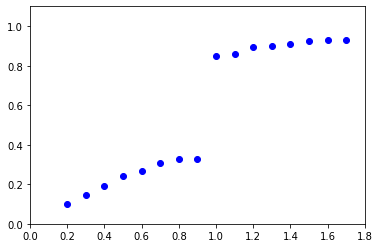

In [14]:
plt.plot(lmbd, sigmaz,'bo')
plt.ylim(0., 1.1)
plt.xlim(0., 1.8)

$ \newcommand{\ket}[1]{\left|{#1}\right\rangle}$
$ \newcommand{\bra}[1]{\left\langle{#1}\right|}$
$$ \newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$$

when it comes to implementation:  
first try to run circuit on simulator 
second try to run on real hardware

long term goal is reproduce figures 5 (Ground state of a spin chain)and 6 (time evolution of operator $\sigma_z$) 

short term goal is initialize the state to  $ \ket{0000}  $ and $\ket{ 1100} $

In [15]:
#Start up and initialize circuit
#Measurement
qc = QuantumCircuit(4, 4)
    #Set correct ground state if lambda < 1
if lambd < 1:
    qc.x(3)
    qc.barrier()

    #Apply disentangling gates
qc = bog(qc, 0, 1, thetak(1.))
qc = fourier(qc, 0, 1, 2*np.pi/n)
qc = fourier(qc, 2, 3, 0.)
qc = fourier(qc, 0, 1, 0.)
qc = fourier(qc, 2, 3, 0.)
    #Set measurement step
for i in range(0,4):
    qc.measure(i,i)
    

    
    #Choose provider and backend
#provider = IBMQ.get_provider()
#provider = AerProvider()
#backend = Aer.get_backend('statevector_simulator')
backend = Aer.get_backend('qasm_simulator')
#backend = provider.get_backend('ibmq_qasm_simulator')
#backend = provider.get_backend('ibmqx4')
#backend = provider.get_backend('ibmqx2')
#backend = provider.get_backend('ibmq_16_melbourne')

shots = 1024
max_credits = 10 #Max number of credits to spend on execution
job = execute(qc, backend=backend, shots=shots, max_credits=max_credits)  
job_monitor(job)
result = job.result()
counts = result.get_counts(qc)
#print(counts['0000'])
plot_histogram(counts)

 # had to comment this part because qc is a local variable in groundstate function now - Bruna

TypeError: thetak() missing 1 required positional argument: 'lamb'

In [ ]:
phi = np.arccos(lambd/np.sqrt(1+lambd**2))/2
#print(result.get_statevector(qc))
print("|0000> probability should be: ",np.cos(phi)**2)
print("|0011> probability should be: ",np.sin(phi)**2 )

In [ ]:
#print(counts['0000'])